# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Question to be answered in this analysis

Which demographic groups respond best to which offer type?

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import datetime 
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score,fbeta_score
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## l) Data Exploration

### Data Preparation

In order to analyze the problem better in next sections, first need to explore the datasets which includes checking the missing value, visualizing the data distribution, etc. In that way, we can have a better understanding on how the dataset looks like and how we cam featurize the data to make it ready for modelling

### 1. Portfolio Dataset

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [4]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [5]:
def cleaned_portfolio(portfolio):
    '''
    Cleaning the portfolio dataset and making it ready for analysis
    
    INPUT:
    portfolio - the portfolio dataframe to be cleaned
    
    OUTPUT:
    portfolio - the cleaned portfolio dataframe
    
    '''
    cleaned_portfolio = portfolio.copy()
    
    #convert  duration in hours 
    cleaned_portfolio['duration']=cleaned_portfolio['duration']*24
    
    cleaned_portfolio['web'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    cleaned_portfolio['email'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    cleaned_portfolio['mobile'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    cleaned_portfolio['social'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    #replace id to offer_id
    cleaned_portfolio.rename(columns={'id':'offer_id'},inplace=True)
        
    #drop channels
    cleaned_portfolio.drop(['channels'],axis=1,inplace=True)
    
    return cleaned_portfolio

In [6]:

clean_portfolio = cleaned_portfolio (portfolio)

In [7]:
clean_portfolio

,difficulty,duration,offer_id,offer_type,reward,web,email,mobile,social
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,96,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,72,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,168,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0


## 2. Profile Dataset

In [8]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [9]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [10]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [11]:
#Age Column
profile[profile.age == 118][['gender','age','income']]

,gender,age,income
0,None,118,NaN
2,None,118,NaN
4,None,118,NaN
6,None,118,NaN
7,None,118,NaN
9,None,118,NaN
10,None,118,NaN
11,None,118,NaN
17,None,118,NaN
23,None,118,NaN


The above analysis clears that customers with age 118 are mostly either fake entries or abnormalities or customer who did not wanted to disclose that information. If need be, we can drop them during the preprocessing of the dataset.

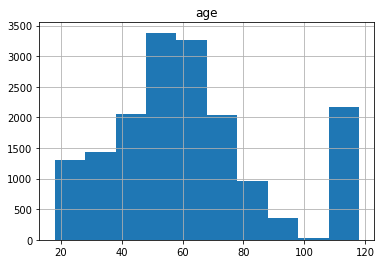

In [12]:
# age distribution
profile.hist(column='age');

From the above graph we can see that there are some ages at 118 and a few above 100.

In [13]:
def clean_profile(profile):
    '''
    Cleaning the profile dataset and making it ready for analysis
    
    INPUT:
    profile - the profile dataframe to be cleaned
    
    
    '''
    cleaned_profiled = profile.copy()
    
    # age: (numeric) missing value encoded as 118
    cleaned_profiled['age'] = cleaned_profiled['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # drop all missing values
    cleaned_profiled.dropna(inplace=True)
    
    #Convert to datetime
    cleaned_profiled['became_member_on'] = pd.to_datetime(profile['became_member_on'], format="%Y%m%d")
    
    
    #add Age_group column
    cleaned_profiled.loc[(cleaned_profiled.age < 20) , 'Age_group'] = 'Under-20'
    cleaned_profiled.loc[(cleaned_profiled.age >= 20) & (cleaned_profiled.age <= 45) , 'Age_group'] = '20-45'
    cleaned_profiled.loc[(cleaned_profiled.age >= 46) & (cleaned_profiled.age <= 60) , 'Age_group'] = '46-60'
    cleaned_profiled.loc[(cleaned_profiled.age >= 61) & (cleaned_profiled.age <= 80) , 'Age_group'] = '61-80'
    cleaned_profiled.loc[(cleaned_profiled.age >= 81) , 'Age_group'] = '81-101'
    #cleaned_profiled.drop('age',axis=1,inplace=True)
    
    #Dividing into income range
    #cleaned_profiled['income_range'] = pd.cut(cleaned_profiled['income'], bins=[30000,45000,60000,75000,90000,105000,120000],labels=['30k - 45k', '45k - 60k','60k - 75k','75k - 90k','90k - 105k','105k - 120k'])
    cleaned_profiled.loc[(cleaned_profiled.income <= 45000) , 'income_range'] = '30k - 45k'
    cleaned_profiled.loc[(cleaned_profiled.income >= 45001) & (cleaned_profiled.income <= 60000) , 'income_range'] = '45k - 60k'
    cleaned_profiled.loc[(cleaned_profiled.income >= 60001) & (cleaned_profiled.income <= 75000) , 'income_range'] = '60k - 75k'
    cleaned_profiled.loc[(cleaned_profiled.income >= 75001) & (cleaned_profiled.income <= 90000) , 'income_range'] = '75k - 90k'
    cleaned_profiled.loc[(cleaned_profiled.income >= 90001) & (cleaned_profiled.income <= 105000) , 'income_range'] = '90k - 105k'
    cleaned_profiled.loc[(cleaned_profiled.income >= 105001) & (cleaned_profiled.income <= 120000) , 'income_range'] ='105k - 120k'
    
     #make the respective columns
    cleaned_profiled['membership_year'] = cleaned_profiled.became_member_on.dt.year
    cleaned_profiled['membership_month'] = cleaned_profiled.became_member_on.dt.month
    cleaned_profiled['membership_day'] = cleaned_profiled.became_member_on.dt.day
    
    #replace id to offer_id
    cleaned_profiled.rename(columns={'id':'customer_id'},inplace=True)   
    
    
    return cleaned_profiled

In [14]:
cleaned_profile =clean_profile(profile)

In [15]:
cleaned_profile.isnull().sum()

age                 0
became_member_on    0
gender              0
customer_id         0
income              0
Age_group           0
income_range        0
membership_year     0
membership_month    0
membership_day      0
dtype: int64

In [16]:
 cleaned_profile.head()

,age,became_member_on,gender,customer_id,income,Age_group,income_range,membership_year,membership_month,membership_day
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,46-60,105k - 120k,2017,7,15
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,61-80,90k - 105k,2017,5,9
5,68.0,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,61-80,60k - 75k,2018,4,26
8,65.0,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,61-80,45k - 60k,2018,2,9
12,58.0,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,46-60,45k - 60k,2017,11,11


## 3. Transcript dataset

In [17]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [18]:
def clean_transcript(transcript):
    '''
    Cleaning the transcript dataset and making it ready for analysis
    
    INPUT:
    profile - the transcript dataframe to be cleaned
    
    OUTPUT:
    profile - the cleaned transcript dataframe
    '''
    transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
    
    # clean up the duplicates in offer id and offer_id and meger into one column
    transcript['clean_id'] = np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(), transcript['offer_id'],transcript['offer id'])

    # drop the original id columns
    transcript.drop(['offer id', 'offer_id','value'], axis=1, inplace=True)

    # rename the clean_id column
    transcript.rename(columns={'clean_id': 'offer_id'}, inplace=True)
   
    # rename the reward column
    transcript.rename(columns={'reward': 'money_gained'}, inplace=True)
    
    # rename the person column
    transcript.rename(columns={'person': 'customer_id'}, inplace=True)
    
    #replace nan
    transcript.fillna(0 , inplace=True)
    
    return transcript

In [19]:
cleaned_transcript=clean_transcript(transcript)

In [20]:
cleaned_transcript.head()

,event,customer_id,time,amount,money_gained,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0.0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,0.0,0.0,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,0.0,0.0,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,0.0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [21]:
cleaned_transcript.isnull().sum()

event           0
customer_id     0
time            0
amount          0
money_gained    0
offer_id        0
dtype: int64

In [22]:
cleaned_transcript.describe()

,time,amount,money_gained
count,306534.000000,306534.000000,306534.000000
mean,366.382940,5.792023,0.537219
std,200.326314,21.337137,1.805208
min,0.000000,0.000000,0.000000
25%,186.000000,0.000000,0.000000
50%,408.000000,0.000000,0.000000
75%,528.000000,7.100000,0.000000
max,714.000000,1062.280000,10.000000


## II).Exploratory Data Analysis

## Questions

1.	Gender distribution 
2.	What are the age group of the customer?
3.	How the income range varies for each gender?
4.	How is the data is divided between different offers?
5.	How is the data is divided between different events?
6.	What are the most popular offers for each gender?
7.	What are the most popular offers in the various age groups?
8.	 How customers respond to the offer type?
9.	How customer respond to the offer type which is received through Email?
10.	How customer respond to the offer type which is received through the web?
11.	How customer respond to the offer type which is received through Mobile?
12.	How customer respond to the offer type which is received through Social?
13.	What is the response to the offers in the various age groups?
14.	What is the response to the offers in gender? 
15.	How is the event varying in the various income range?

### Merging data frames for EDA

In [23]:
def merge_data(clean_portfolio,cleaned_profile,cleaned_transcript):
    """
    Merge cleaned data frames for EDA
       
    Parameters
    ---------- 
    portfolio : cleaned portfolio data frame
    profile : cleaned profile data frame
    transcript : cleaned transcript data frame
      
    Returns
    -------
    merged_df: merged data frame
    
    """
    
    merged_df = pd.merge(cleaned_profile, cleaned_transcript, on='customer_id')
    merged_df = pd.merge(merged_df,clean_portfolio, on='offer_id')
    
    
    return merged_df

In [24]:
merged_df = merge_data(clean_portfolio, cleaned_profile, cleaned_transcript)

In [25]:
merged_df.head()

,age,became_member_on,gender,customer_id,income,Age_group,income_range,membership_year,membership_month,membership_day,...,money_gained,offer_id,difficulty,duration,offer_type,reward,web,email,mobile,social
0,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,46-60,105k - 120k,2017,7,15,...,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,168,bogo,5,1,1,1,0
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,46-60,105k - 120k,2017,7,15,...,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,168,bogo,5,1,1,1,0
2,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,61-80,90k - 105k,2017,5,9,...,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,168,bogo,5,1,1,1,0
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,61-80,90k - 105k,2017,5,9,...,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,168,bogo,5,1,1,1,0
4,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,61-80,90k - 105k,2017,5,9,...,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,168,bogo,5,1,1,1,0


In [26]:
merged_df.isnull().sum()

age                 0
became_member_on    0
gender              0
customer_id         0
income              0
Age_group           0
income_range        0
membership_year     0
membership_month    0
membership_day      0
event               0
time                0
amount              0
money_gained        0
offer_id            0
difficulty          0
duration            0
offer_type          0
reward              0
web                 0
email               0
mobile              0
social              0
dtype: int64

### 1. **Gender Distribution**

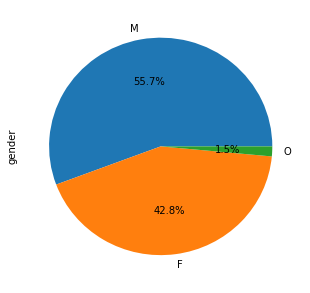

In [27]:
merged_df.gender.value_counts().plot(kind='pie' , figsize=(5, 5), autopct='%1.1f%%')

### 2.What are the age group of the customers?

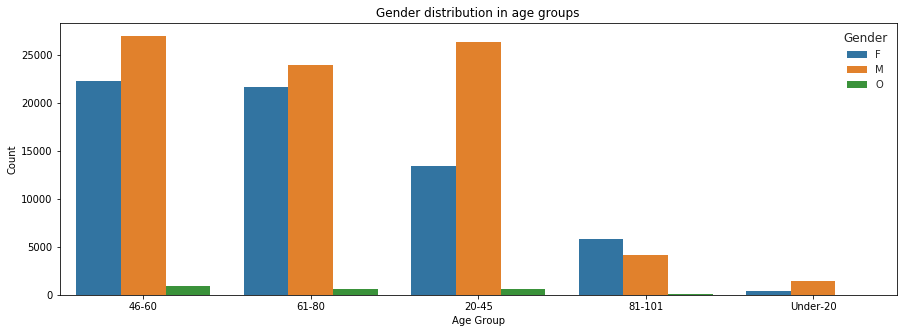

In [28]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "Age_group", hue= "gender", data=merged_df)
sns.set(style="darkgrid")
plt.title('Gender distribution in age groups')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Gender')

### 3. How the income range varies for each gender?

In [29]:
merged_df['income'].mean()

66414.119149222141

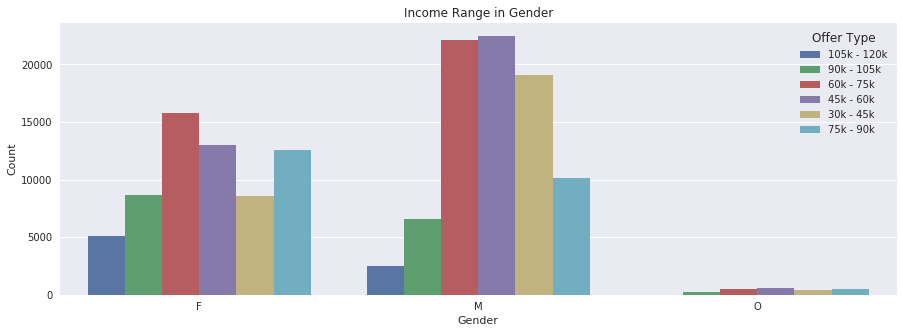

In [30]:
#Q2. 
plt.figure(figsize=(15, 5))
sns.countplot(x= "gender", hue= "income_range", data=merged_df)
sns.set(style="darkgrid")
plt.title('Income Range in Gender')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.legend(title='Offer Type')

### 4.How is the data is divided between different offer?

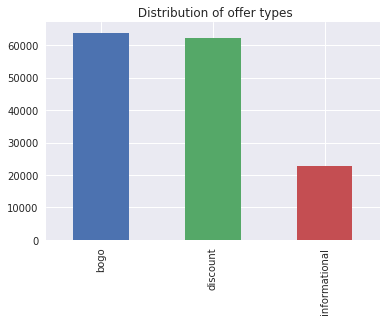

In [31]:
merged_df['offer_type'].value_counts().plot.bar(title=' Distribution of offer types')

### 5. How is the data is divided between different events?

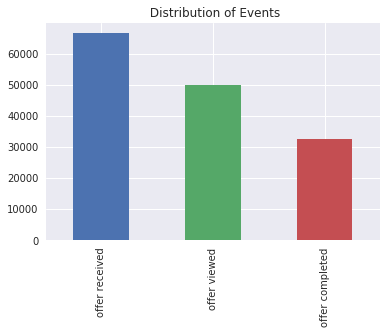

In [32]:
merged_df['event'].value_counts().plot.bar(title=' Distribution of Events')

### 6.What are the most popular offers for each gender?

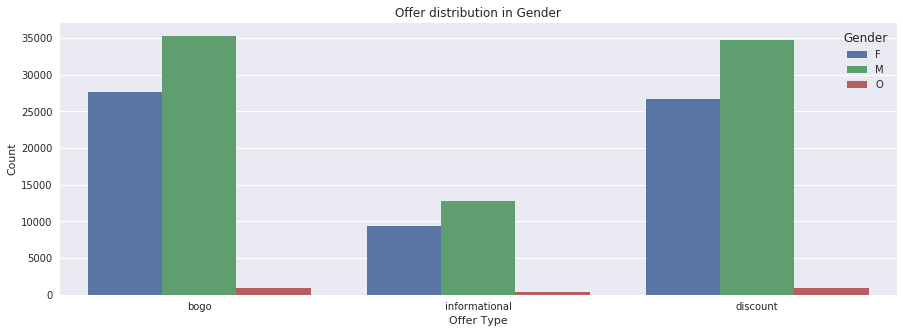

In [33]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "offer_type", hue= "gender", data=merged_df)
sns.set(style="darkgrid")
plt.title('Offer distribution in Gender')
plt.ylabel('Count')
plt.xlabel('Offer Type')
plt.legend(title='Gender')

Male got offer type as compare to other gender

### 7.What are the most popular offers in the various age groups?

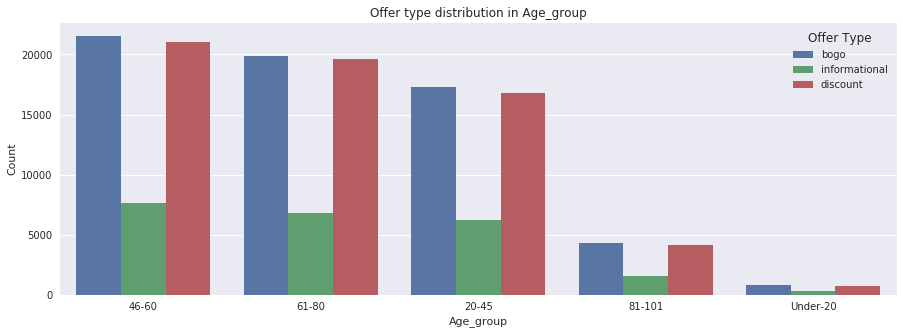

In [34]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "Age_group", hue= "offer_type", data=merged_df)
sns.set(style="darkgrid")
plt.title('Offer type distribution in Age_group')
plt.ylabel('Count')
plt.xlabel('Age_group')
plt.legend(title='Offer Type')

Age_group between 46-80 got more offer type as comapre to other Age _group

### 8. How customer responses the offer type?

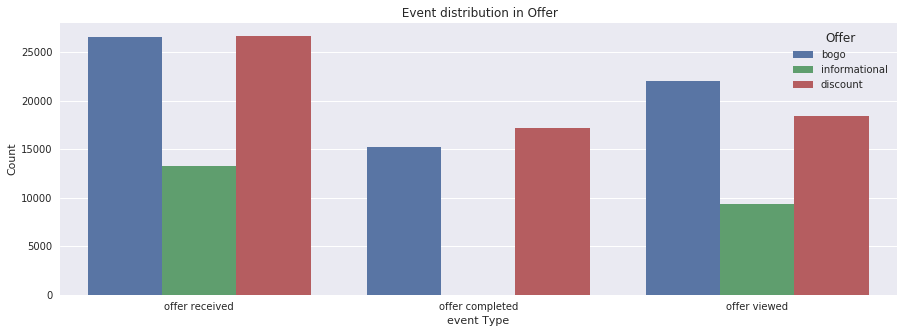

In [35]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "offer_type", data=merged_df)
sns.set(style="darkgrid")
plt.title(' Event distribution in Offer')
plt.ylabel('Count')
plt.xlabel('event Type')
plt.legend(title='Offer')

Customer used  the discount and completed as compare to other Offer type

### 9. How customer responses to the offer type which is received through Email?

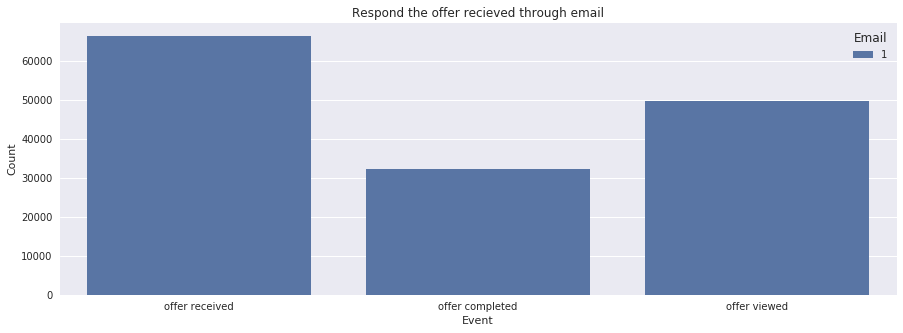

In [36]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "email", data=merged_df)
sns.set(style="darkgrid")
plt.title('Respond the offer recieved through email')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Email')

### 10. How customer responses to the offer type which is received through web?

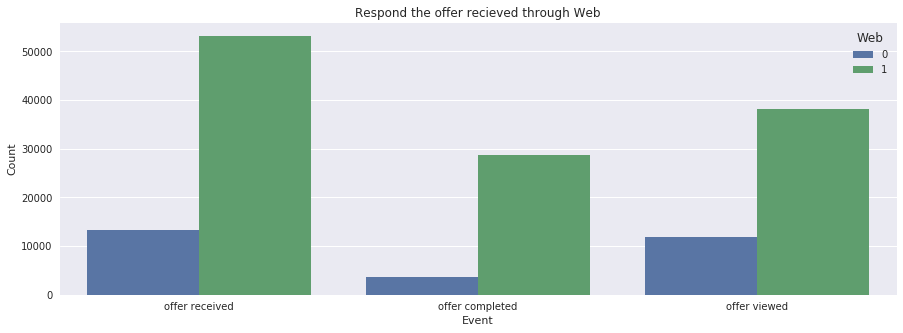

In [37]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "web", data=merged_df)
sns.set(style="darkgrid")
plt.title('Respond the offer recieved through Web')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Web')

### 11. How customer responses to the offer type which is received through Mobile?

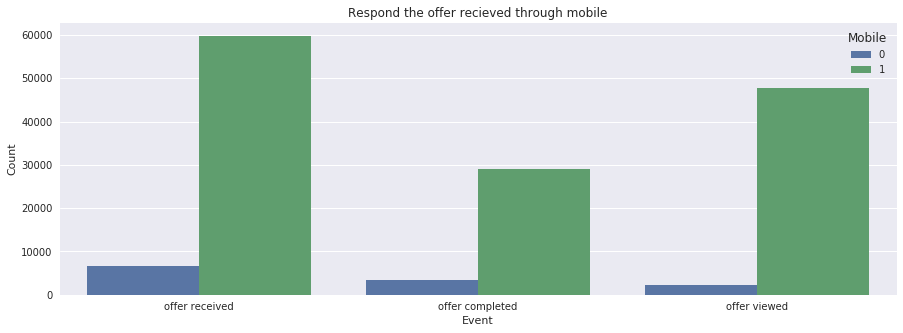

In [38]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "mobile", data=merged_df)
sns.set(style="darkgrid")
plt.title('Respond the offer recieved through mobile')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Mobile')

### 12. How customer responses to the offer type which is received through Social?

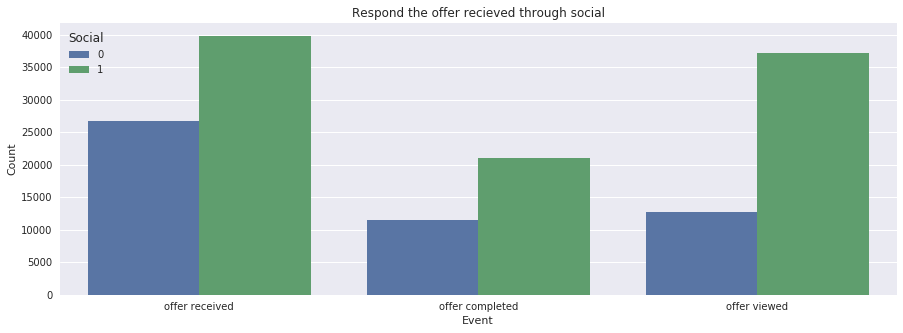

In [39]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "social", data=merged_df)
sns.set(style="darkgrid")
plt.title('Respond the offer recieved through social')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Social')

###  13.What is the response to the offers in the various age groups?

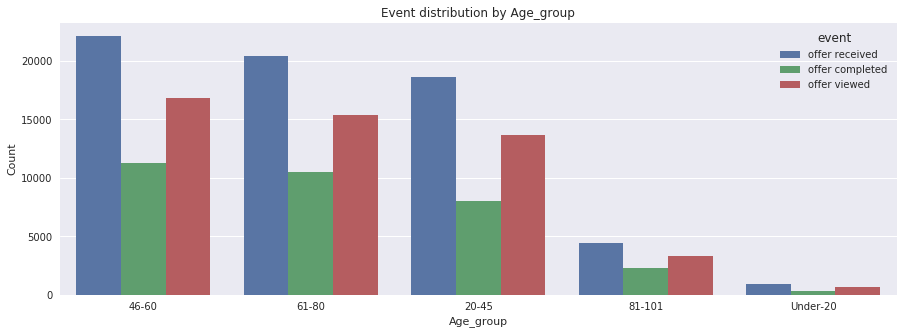

In [40]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "Age_group", hue= "event", data=merged_df)
sns.set(style="darkgrid")
plt.title('Event distribution by Age_group')
plt.ylabel('Count')
plt.xlabel('Age_group')
plt.legend(title='event')

Customer of age group 46-60  and 61- 80 complete the offer .

### 14.What is the response to the offers in gender?

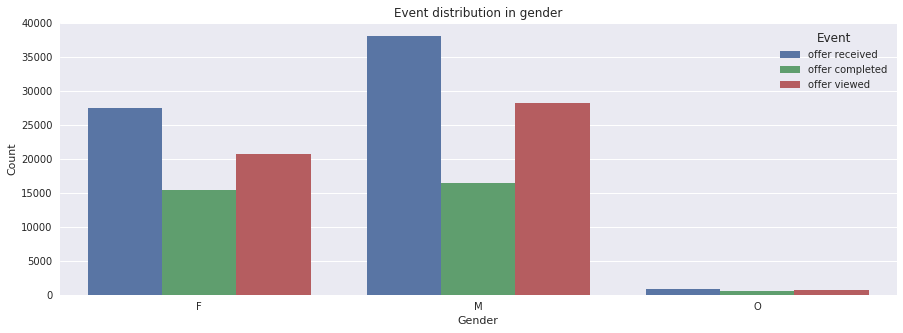

In [41]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "gender", hue= "event", data=merged_df)
sns.set(style="darkgrid")
plt.title('Event distribution in gender')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.legend(title='Event')

 Male and Female almost equally complete the offer. As compare to Female, Male  recieved more offer.

### 15. How is the event varies in the various income range ?

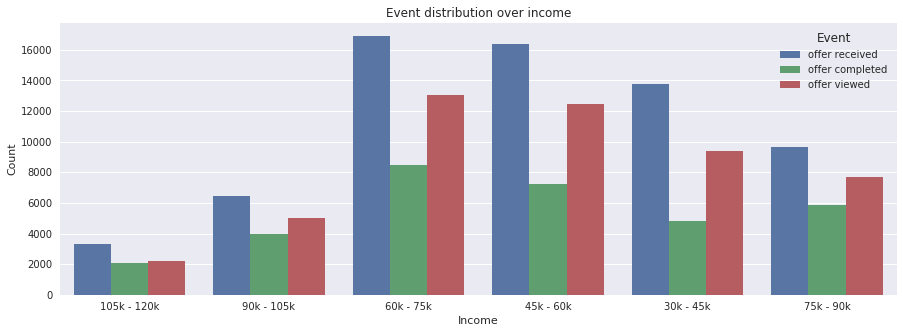

In [42]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "income_range", hue= "event", data=merged_df)
sns.set(style="darkgrid")
plt.title('Event distribution over income')
plt.ylabel('Count')
plt.xlabel('Income')
plt.legend(title='Event')

Income range getween 45000-70000 customer completed the offer

## Ill) Build a Machine Learning model to predict response of a customer to an offer

## 1.Data Preparation and Cleaning

## Modelling

Making sure our data is ready and optimized for the fitting that will happen later.

In [43]:
def clean_merged(merged_df):
    """
    Clean merged data frame  .
    
    Parameters
    ----------
    cleaned_merged: input data frame(profile,transcript,profile)
    
    Returns
    -------
    cleaned_merged: cleaned data frame as per tasks
       
    """
    cleaned_merged = merged_df.copy()
    
    #process categorical variables
    #categorical = ['offer_type', 'gender', 'Age_group']
    categorical = ['offer_type', 'gender']
    cleaned_merged = pd.get_dummies(cleaned_merged, columns = categorical)
    
    #drop became_member_on column
    cleaned_merged.drop(['became_member_on','income_range','Age_group','membership_month','membership_day'],axis=1, inplace=True)    
    
    #process offer_id column
    offerids = cleaned_merged['offer_id'].unique().tolist()
    o_mapping = dict( zip(offerids,range(len(offerids))) )
    cleaned_merged.replace({'offer_id': o_mapping},inplace=True)
    
    #process customer_id column
    cusids = cleaned_merged['customer_id'].unique().tolist()
    c_mapping = dict( zip(cusids,range(len(cusids))) )
    cleaned_merged.replace({'customer_id': c_mapping},inplace=True)
    
    #process numerical variables
    #normalizing the data
    #initialize a MinMaxScaler, then apply it to the features
    scaler = MinMaxScaler() # default=(0, 1)
    numerical = ['income', 'difficulty', 'duration', 'reward','money_gained', 'time','age']
    cleaned_merged[numerical] = scaler.fit_transform(cleaned_merged[numerical])
    
    #encode 'event' data to numerical values according to task 2
    cleaned_merged['event'] = cleaned_merged['event'].map({'offer received':1, 'offer viewed':2, 'offer completed':3})
   
    return cleaned_merged

In [44]:
cleaned_merged= clean_merged(merged_df)

In [45]:
cleaned_merged.head()

,age,customer_id,income,membership_year,event,time,amount,money_gained,offer_id,difficulty,...,web,email,mobile,social,offer_type_bogo,offer_type_discount,offer_type_informational,gender_F,gender_M,gender_O
0,0.445783,0,0.911111,2017,1,0.571429,0.0,0.0,0,0.25,...,1,1,1,0,1,0,0,1,0,0
1,0.445783,0,0.911111,2017,3,0.739496,0.0,0.5,0,0.25,...,1,1,1,0,1,0,0,1,0,0
2,0.686747,1,0.777778,2017,1,0.000000,0.0,0.0,0,0.25,...,1,1,1,0,1,0,0,1,0,0
3,0.686747,1,0.777778,2017,2,0.008403,0.0,0.0,0,0.25,...,1,1,1,0,1,0,0,1,0,0
4,0.686747,1,0.777778,2017,3,0.184874,0.0,0.5,0,0.25,...,1,1,1,0,1,0,0,1,0,0


In [46]:
cleaned_merged.columns

Index(['age', 'customer_id', 'income', 'membership_year', 'event', 'time',
       'amount', 'money_gained', 'offer_id', 'difficulty', 'duration',
       'reward', 'web', 'email', 'mobile', 'social', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational', 'gender_F',
       'gender_M', 'gender_O'],
      dtype='object')

In [47]:
cleaned_merged.describe()

,age,customer_id,income,membership_year,event,time,amount,money_gained,offer_id,difficulty,...,web,email,mobile,social,offer_type_bogo,offer_type_discount,offer_type_informational,gender_F,gender_M,gender_O
count,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.0,148805.000000,148805.000000,148805.000000,...,148805.000000,148805.0,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000
mean,0.443124,7292.622177,0.404601,2016.576365,1.771130,0.496597,0.0,0.107887,4.706703,0.394528,...,0.806747,1.0,0.917160,0.658311,0.428978,0.418743,0.152280,0.428205,0.557078,0.014717
std,0.207151,4264.461987,0.238855,1.186534,0.782658,0.277747,0.0,0.245254,2.796607,0.252067,...,0.394851,0.0,0.275641,0.474277,0.494932,0.493355,0.359293,0.494820,0.496733,0.120419
min,0.000000,0.000000,0.000000,2013.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.301205,3570.000000,0.233333,2016.000000,1.000000,0.235294,0.0,0.000000,3.000000,0.250000,...,1.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.457831,7252.000000,0.388889,2017.000000,2.000000,0.571429,0.0,0.000000,5.000000,0.500000,...,1.000000,1.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.590361,11021.000000,0.566667,2017.000000,2.000000,0.714286,0.0,0.000000,7.000000,0.500000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,14819.000000,1.000000,2018.000000,3.000000,1.000000,0.0,1.000000,9.000000,1.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [48]:
#Split the data into X(features) and y(target) label
y = cleaned_merged['event']
X = cleaned_merged.drop('event', axis=1)

In [49]:
X.shape

(148805, 21)

In [50]:
y.shape

(148805,)

## 2.Split train and test data

We will now split the data (both features and their labels) into training and test sets, taking 60% of data for training and 40% for testing.

In [51]:
#Dividing the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [52]:
X_train.head()

,age,customer_id,income,membership_year,time,amount,money_gained,offer_id,difficulty,duration,...,web,email,mobile,social,offer_type_bogo,offer_type_discount,offer_type_informational,gender_F,gender_M,gender_O
125889,0.614458,2536,0.500000,2017,0.571429,0.0,0.0,8,1.00,1.000000,...,1,1,0,0,0,1,0,1,0,0
13344,0.108434,5139,0.044444,2015,0.000000,0.0,0.0,0,0.25,0.571429,...,1,1,1,0,1,0,0,0,1,0
47994,0.240964,12586,0.666667,2017,0.252101,0.0,0.0,3,0.50,0.571429,...,0,1,1,1,1,0,0,0,1,0
3547,0.397590,1387,0.500000,2016,0.504202,0.0,0.5,0,0.25,0.571429,...,1,1,1,0,1,0,0,1,0,0
145936,0.048193,4562,0.400000,2017,0.571429,0.0,0.0,9,0.50,0.285714,...,1,1,1,1,1,0,0,0,1,0


In [53]:
print("Training set: {} rows".format(X_train.shape[0]))
print("Testing set: {} rows".format(X_test.shape[0]))


Training set: 89283 rows
Testing set: 59522 rows


## 3. Training and Testing

We will consider the F1 score as the model metric to assess the quality of the approach and determine which model gives the best results. 

In [54]:
# defining a function to calculate the accuracy for the models we will try below. Inspired by Stackoverflow
def train_test(clf):
    """
    Return train and test F1 score along with the model name
       
    Parameters
    --------
    clf: estimator instance
    
    Returns
    --------
    train_f1: train data F1 score
    test_f1: test data F1 score
    name: model name
       
    """
    
    clf.fit(X_train, y_train)
    train_prediction = clf.predict(X_train)
    test_predictions = clf.predict(X_test)
    train_f1 =  accuracy_score(y_train, train_prediction)*100
    test_f1= fbeta_score(y_test, test_predictions, beta = 0.5, average='micro' )*100
    name = clf.__class__.__name__
     
    return train_f1, test_f1,name

### i) KNeighborsClassifier

In [55]:
#1.KNN Classifier
clf_A = KNeighborsClassifier(n_neighbors = 5)
a_train_f1, a_test_f1,a_model = train_test(clf_A)
print(f'Accuracy of K-NN classifier on training set: {a_train_f1}%.')
print(f'Prediction Accuracy: {a_test_f1}%')

Accuracy of K-NN classifier on training set: 54.41237413617374%.
Prediction Accuracy: 32.473707200698904%


### ii) RandomForestClassifier

In [56]:
#2.Random Forest
clf_B = RandomForestClassifier(random_state =10)
b_train_f1, b_test_f1,b_model = train_test(clf_B)
print(f'Accuracy of SVM classifier on training set: {b_train_f1}%.')
print(f'Prediction Accuracy: {b_test_f1}%')

Accuracy of SVM classifier on training set: 94.66863792659296%.
Prediction Accuracy: 71.42905144316387%


### iii) DecisionTreeClassifier

In [57]:
#3.Decision Tree Classifier
clf_C = DecisionTreeClassifier(random_state =10)
c_train_f1, c_test_f1,c_model= train_test(clf_C)
print(f'Accuracy of Decision Tree classifier on training set: {c_train_f1}%.')
print(f'Prediction Accuracy: {c_test_f1}%')

Accuracy of Decision Tree classifier on training set: 95.627387072567%.
Prediction Accuracy: 85.8506098585397%


### iv) Gaussian Naive Bayes

In [58]:
#4.Naive Bayes
clf_D = GaussianNB()
d_train_f1, d_test_f1,d_model= train_test(clf_D)
print(f'Accuracy of Naive Bayes classifier on training set: {d_train_f1}%.')
print(f'Prediction Accuracy: {d_test_f1}%')

Accuracy of Naive Bayes classifier on training set: 63.797139433038765%.
Prediction Accuracy: 63.804979671382014%


## 4. Model Result
###         Model comparisons & evaluation against the model metric

In [59]:
models = {'Model': [a_model, b_model, c_model,d_model], 
          'Train Accuracy ':[a_train_f1, b_train_f1, c_train_f1,d_train_f1], 
          'Predicting Accuracy': [a_test_f1 , b_test_f1, c_test_f1,d_test_f1]
         }
          
comp = pd.DataFrame(models)

In [60]:
comp

,Model,Train Accuracy,Predicting Accuracy
0,KNeighborsClassifier,54.412374,32.473707
1,RandomForestClassifier,94.668638,71.429051
2,DecisionTreeClassifier,95.627387,85.850610
3,GaussianNB,63.797139,63.804980


The validation set (test data set) is used to evaluate the model. Other models are better than the KNeighborsClassifier. The best score is created by the DecisionTreeClassifier model, as its validate Accuracy score(F1 score) is 85.76, which is much higher than the benchmark and others. The RandomForestClassifier model scores good as well compared to the benchmark, with a test Accuracy score of 67.97. Our problem to solve is not that sensitive which requires very high Predicting Accuracy, so the Predicting Accuracy are good & sufficient and can be used for the classification purpose to predict whether a customer will respond to an offer.

## 5. Model Improvements

In [61]:
clf_C.get_params() #checking the various parameters of decision tree

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 10,
 'splitter': 'best'}

In [62]:
#using gridsearchCV to find the best parameters
params = {'max_leaf_nodes': list(range(80, 100)), 
          'min_samples_split': [2, 3]}
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)
gs.fit(X_train, y_train)
print(f'Best Score: {gs.best_score_*100}%.')
print(f'Best parameters: {gs.best_params_}')

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   41.1s finished


Best Score: 92.58201449324059%.
Best parameters: {'max_leaf_nodes': 80, 'min_samples_split': 2}


In [63]:
#transfering the best model into gs_best and finding the values
gs_best = gs.best_estimator_
clf_g = gs_best
g_train_f1, g_test_f1,g_model= train_test(clf_g)
print(f'Accuracy of the best estimators of decision tree on training set: {round(gs_best.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {g_test_f1}%')

Accuracy of the best estimators of decision tree on training set: 92.71%.
Prediction Accuracy: 92.6464164510601%


From the original fitting to using the best parameters for fitting we gain almost 7% in accuracy which is very good. Even though the accuracy on the training model goes down.

## 6. Model Refinment

We come to conclusion that the best method is the decision tree classifier. Is provides the maximum training accuracy and the best prediciting accuracy. We will go ahead and perform improvements on this model. It is good here because we have good amount of data to work with.

# lV) Conclusion

In this project, which I explored the Starbucks data set, analyzed, visualized, and created supervised machine learning models. Overall, I found this project interesting and challenging, mainly due to the structure of the data especially the transcript dataset.First, I've examined every dataset, evaluated its different aspects in order to gain an overall understanding of the data. Then I switched to the pre-processing portion. Pre-processing Data was the job that took much of the time and energy. The dataset is a little complicated and the data included allowed me to use my wrangling and pre-processing expertise to get the final clean version of the three datasets.

## Quick Facts and Interesting analysis

#### Q1-Which demographic groups respond best to which offer type?
- Male and Female almost equally complete the offer. As compared to females, Males received more offers. Customers of age between 46–80 and income between 60000–80000 respond most to offers type 'BOGO' and 'Discount' So it will be good to send BOGO and Discount offers to these customers

#### Q2- Which are the most popular offer.?
- The most common offer type among all age groups is the BOGO, followed by the Discount Offers. Whereas, the least common offer to be sent is the informational offers. I believe that BOGO offers are more attractive compared to other offers provided by Starbucks.

#### Q3- Most of the customer belongs to which income range?
- The income of everyone is between 30k and 120k where men earn more in the lower spectrum (less than 75k) and women earn more in the higher spectrum.

#### Q4- Any Abnormalities is the profile?
- Customers with age 118 are mostly either fake entries or abnormalities or customers who did not want to disclose that information. If need be, we can drop them during the preprocessing of the dataset.

#### Q5- Which Machine learning model to predict whether a customer will complete an offer?
- The problem that we chose to solve was to created a Machine Learning model  model to predicts whether a customer will respond to an offer. The strategy we followed has a few steps. First, we combined offer portfolio, customer profile, and transaction data. Second, we did some more pre-processing to the combined data to fit into the model. Third, we assessed the Accuracy score of a KNeighborsClassifier, RandomForestClassifier, DecisionTreeClassifier, and Gaussian Naive Bayes model to determine which model best represents our data on hand. We compared the performance and the DecisionTreeClassifier model performs best among them.
    
    Finally, I would conclude that I have successfully made a model that tells with 92% accuracy what happens when a customer is presented with an offer.

## V) Improvements:

Although this was a very in-depth analysis, there is still a lot of room for improvement. If you’d like to dig further into the data, here are some ideas:

- There may be overfitting which can be solved by considering more data, in the future.
- Build a Machine Learning Pipeline to seamlessly classify new data.